[RQ4] What is the most common way of payments? Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.



In [1]:
#Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import functions
import datetime
from scipy.stats import chi2_contingency

import time

In [2]:
# directory path for csv files (dataset from Jan to Jun 2018)
df_names=['data/yellow_tripdata_2018-01.csv','data/yellow_tripdata_2018-02.csv',
          'data/yellow_tripdata_2018-03.csv','data/yellow_tripdata_2018-04.csv',
         'data/yellow_tripdata_2018-05.csv','data/yellow_tripdata_2018-06.csv']

# taxi_zone_lookup.csv file
taxi_zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')

# names of the boroughs
borough_lst = list(np.unique(taxi_zone_lookup.Borough))


# The way payments are executed in each borough 

In [3]:
def payments_per_borough(borough_lst):
    res=[] #list to store parts of dataframe grouped by Borough and payment_type

    for i,df_name in enumerate(df_names): #repeating it for every fail(aka month)
            # load the ith dataframe, taking only 2 columns
            df = pd.read_csv(df_name,usecols= ['payment_type','PULocationID'])
            
            # merging it with taxi_zone_lookup file(left-join) 
            df=pd.merge(df,taxi_zone_lookup,how='left',left_on='PULocationID',right_on='LocationID')

            res.append(df.groupby(['Borough','payment_type']).count().iloc[:,0]) 
    
    #concatenating the results for all months and summing the values for each payment type
    res=pd.DataFrame(pd.concat(res,axis=1).sum(axis=1))
    res.reset_index(inplace=True)
    return res

In [5]:
start = time.time()
res=payments_per_borough(borough_lst)
print ("-------- s:", str(time.time() - start),"--------")

-------- s: 75.07458806037903 --------


In [6]:
# res
res

,Borough,payment_type,0
0,Bronx,1,27788
1,Bronx,2,26147
2,Bronx,3,1515
3,Bronx,4,360
4,Brooklyn,1,441890
5,Brooklyn,2,230533
6,Brooklyn,3,8789
7,Brooklyn,4,1923
8,EWR,1,3036
9,EWR,2,551


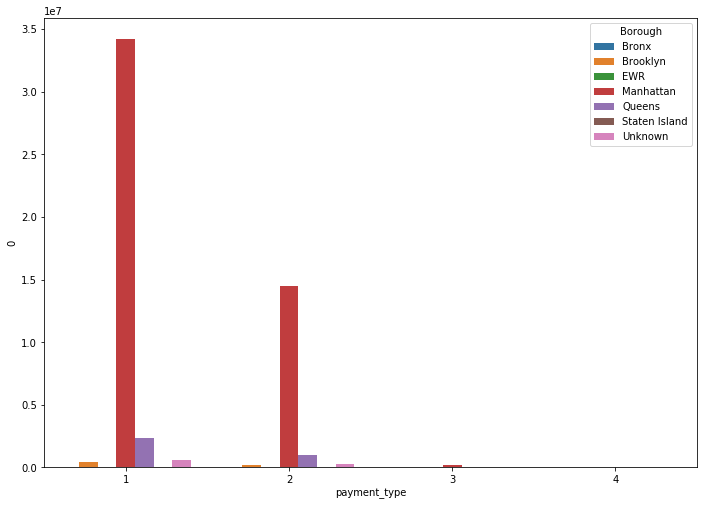

In [7]:
# All boroughs
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(y=0, x='payment_type',data=res,hue='Borough')

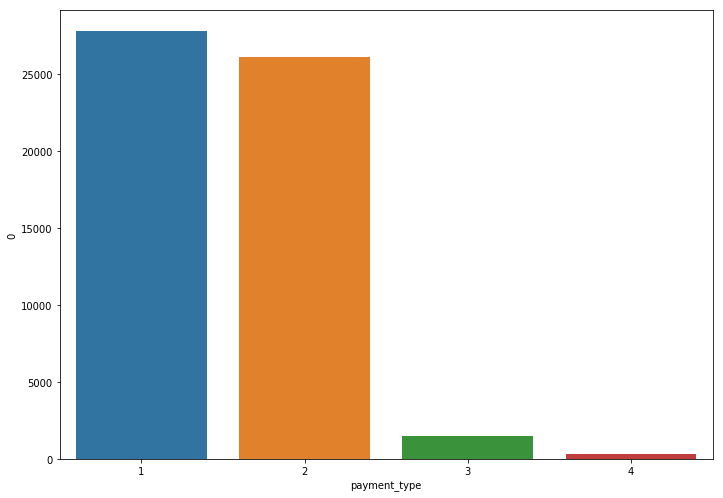

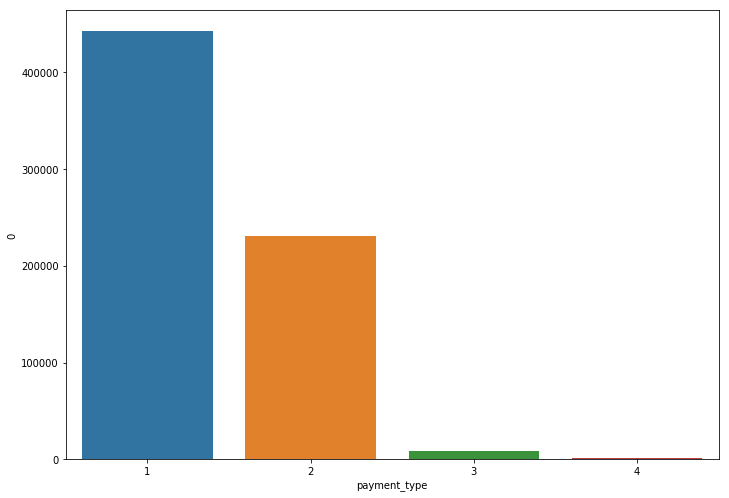

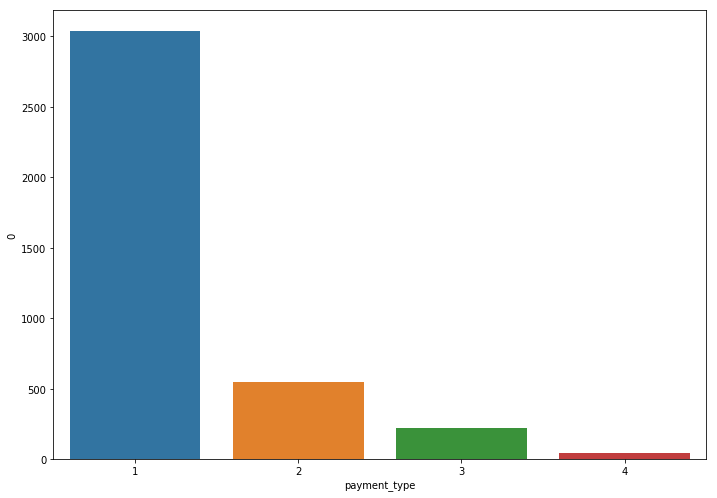

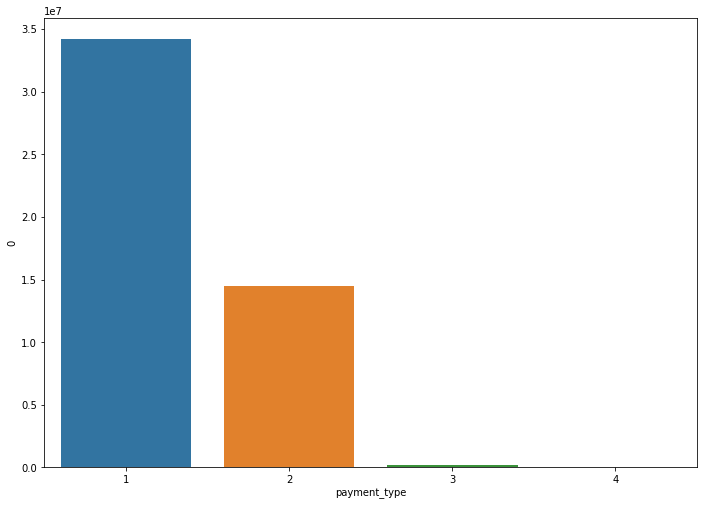

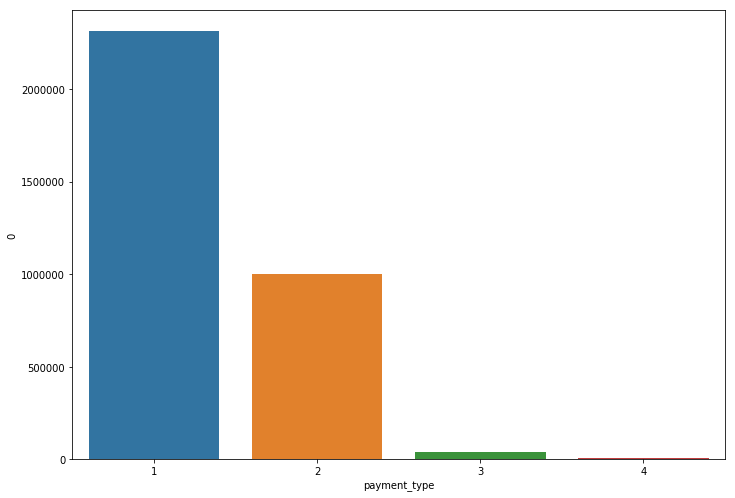

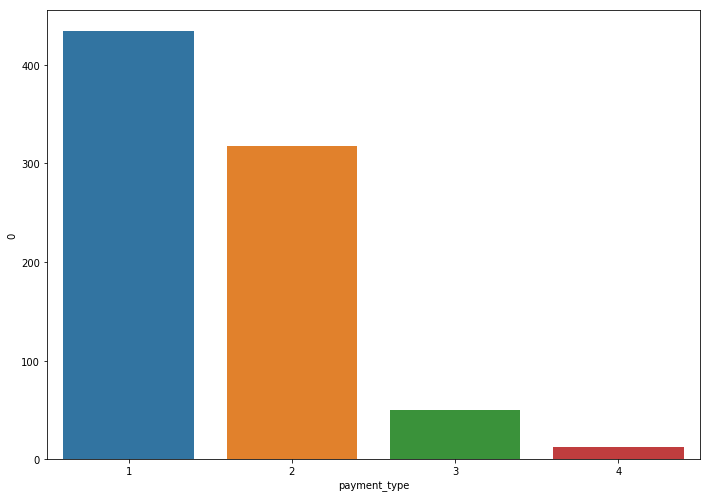

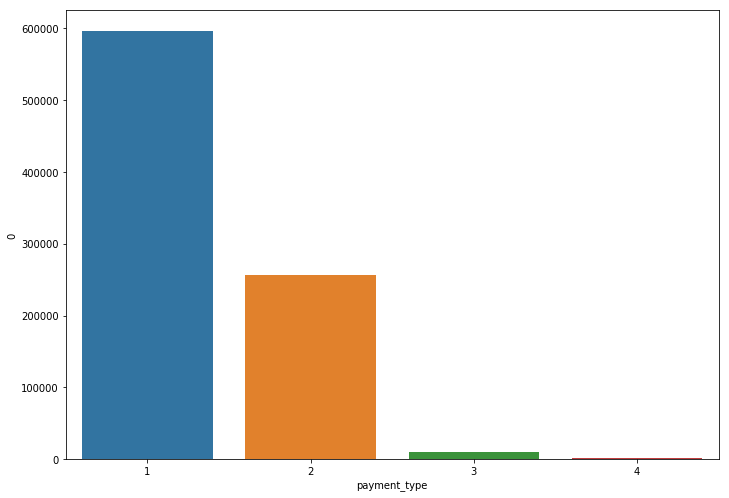

In [9]:
# boroughs one by one

for br in borough_lst:
    conditional_df=res[res.Borough==br]
    if conditional_df.shape[0]>0:
        fig, ax = plt.subplots()
        # the size of A4 paper
        fig.set_size_inches(11.7, 8.27)
        ax = sns.barplot(y=0, x='payment_type',data=res[res.Borough==br])

# The number of payments for any possible means

In [10]:
def all_payments(df_names):
    payment_type_dict = defaultdict(list)
    payment_type=['Credit card','Cash','No charge','Dispute','Unknown','Voided trip']
    payment_type_lst=[]

    for i in range(1,7):
        payment_type_dict[i]=0 #values for each payment_type should be 0 at the beginning
    for i,df_name in enumerate(df_names):
            # load the ith dataframe, taking only the t_pickup_datetime column
            df = pd.read_csv(df_name,usecols= ['payment_type','tpep_pickup_datetime'],parse_dates=['tpep_pickup_datetime'])

            #I think we should consider making a clean method? hmm
            # cleaning the attribute: removing years different from 2018 and months different from ith month
            df=df[(df['tpep_pickup_datetime'].dt.year == 2018) & (df['tpep_pickup_datetime'].dt.month == i+1)]

            x=df.groupby(['payment_type']).count().iloc[:,0]
            for ind,val in enumerate(x):
                payment_type_dict[ind+1]+=val
    for item in payment_type_dict.values():
        payment_type_lst.append(item)
    return payment_type_lst,payment_type

In [12]:
start = time.time()
payment_type_lst,payment_type=all_payments(df_names)
print ("-------- s:", str(time.time() - start),"--------")

-------- s: 109.12613105773926 --------


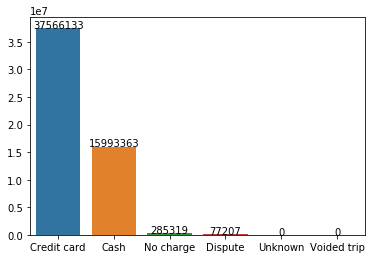

In [13]:
ax = sns.barplot(y=payment_type_lst, x=payment_type)
for ind,val in enumerate(payment_type_lst):
    ax.text(ind,val+1.7,val, color='black', ha="center")
plt.show()

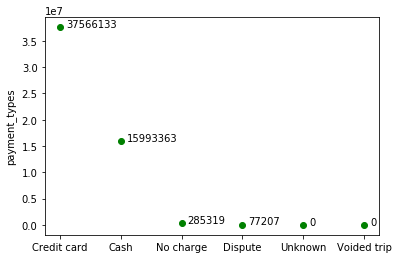

In [14]:
plt.xticks(range(1,7),payment_type)
plt.ylabel("payment_types")
for ind,val in enumerate(payment_type_lst):
    plt.annotate(val,xy=[ind+1.1,val])
plt.plot(range(1,7), payment_type_lst, 'go')

# Chi-squared test

In [ ]:
%%latex
\[H_0\text {={"The method of payment is NOT correlated to the borough"}}\]
\[H_1\text {={"The method of payment is correlated to the borough"}}\]

In [15]:
chi2, p_value, dof, expected = chi2_contingency(res.pivot(index='Borough', columns='payment_type', values=0).fillna(0), correction=False)

In [16]:
contigency_table=res.pivot(index='Borough', columns='payment_type', values=0).fillna(0)
contigency_table

payment_type,1,2,3,4
Borough,,,,
Bronx,27788,26147,1515,360
Brooklyn,441890,230533,8789,1923
EWR,3036,551,220,47
Manhattan,34188788,14480638,226799,63615
Queens,2311245,1000704,37296,8937
Staten Island,434,318,50,13
Unknown,595317,255817,10652,2313


In [17]:
p_value

0.0

p_value is smaller than 0.01. Therefore, Null hypothesis can be rejected. 
And we can conclude that =>{"The method of payment is correlated to the borough"}

In [18]:
contigency_table.iloc[0,:]

payment_type
1    27788
2    26147
3     1515
4      360
Name: Bronx, dtype: int64

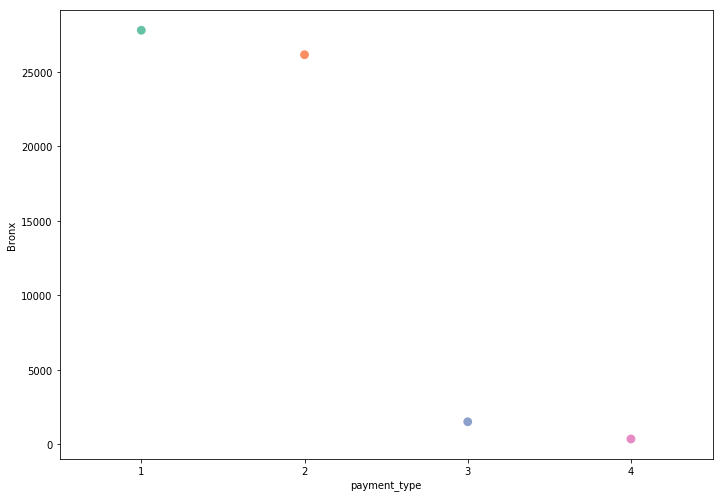

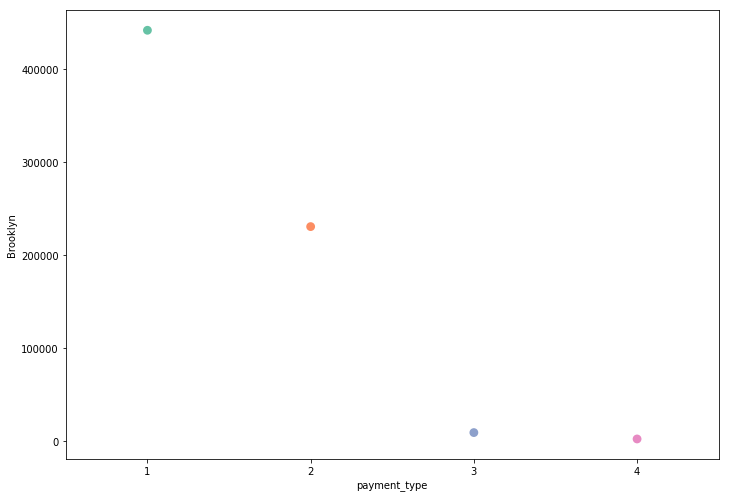

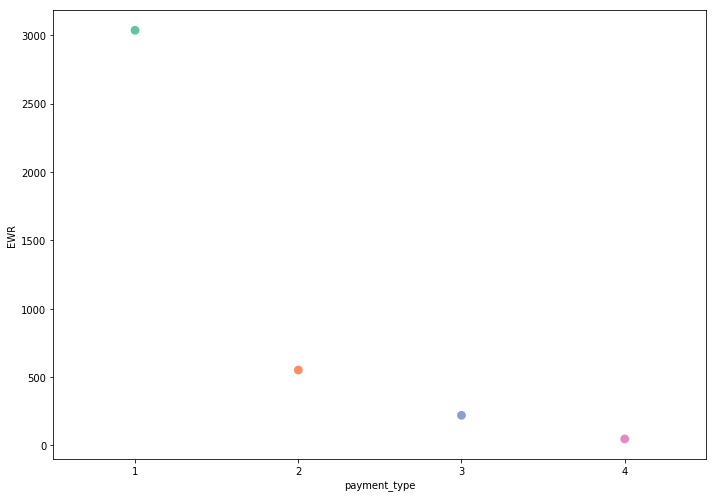

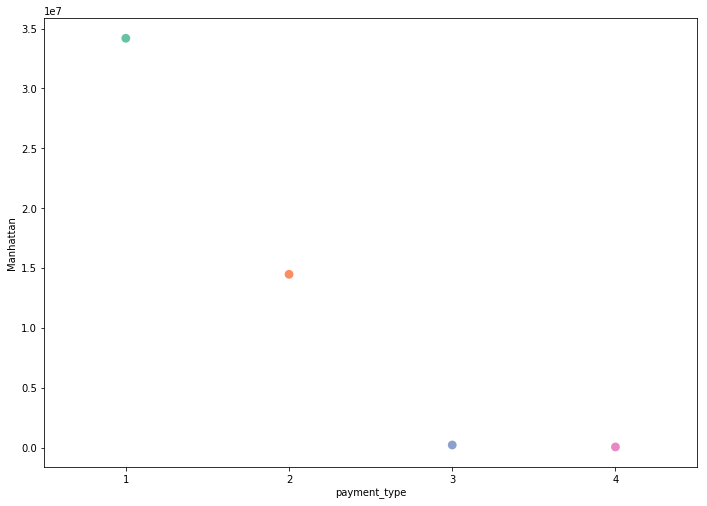

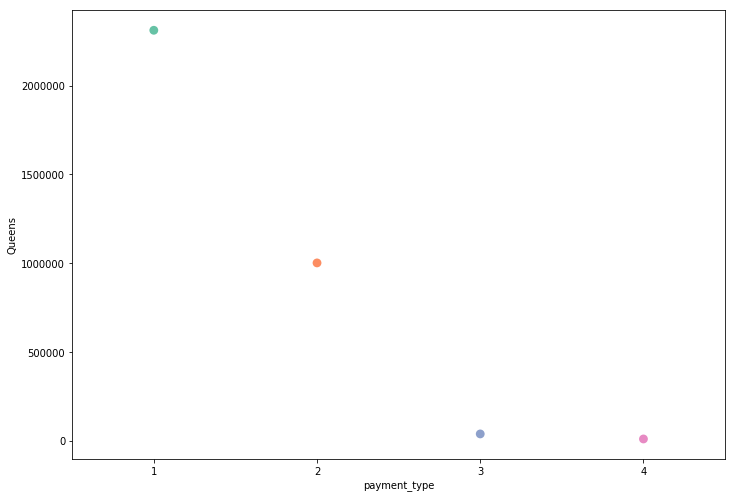

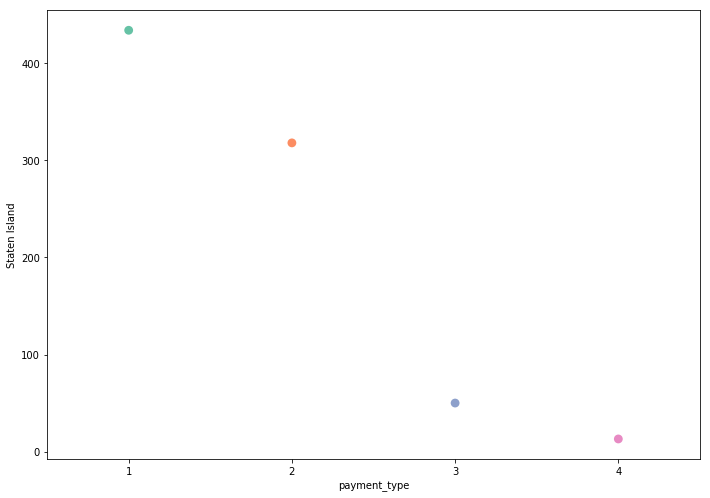

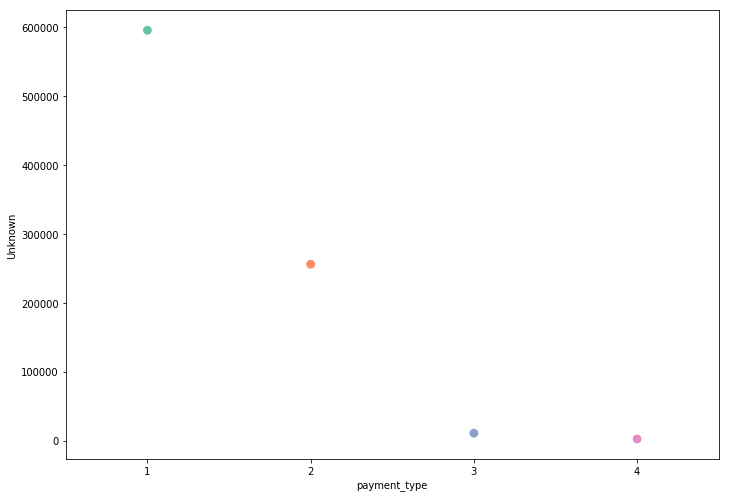

In [19]:
# boroughs one by one

for ind in range(contigency_table.shape[0]):
    row=contigency_table.iloc[ind,:] 
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    ax = sns.pointplot(x=contigency_table.columns, y=row,join=False,palette="Set2")